<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

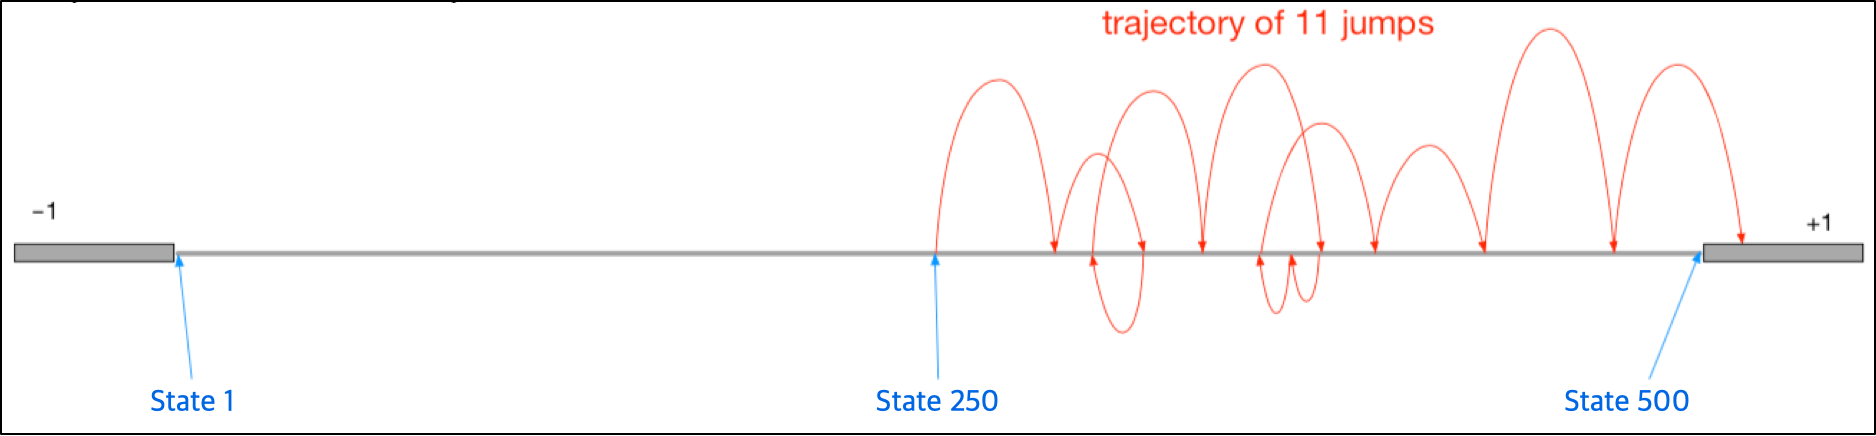

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import jdc
from tqdm import tqdm

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
import plot_script

In [ ]:
class RandomWalkEnvironment(BaseEnvironment):
    def env_init(self, env_info={}):
        """
        Setup for the environment called when the experiment first starts.
        Set parameters needed to setup the 500-state random walk environment.
        Assume env_info dict contains:
        {
            num_states: 500 [int],
            start_state: 250 [int],
            left_terminal_state: 0 [int],
            right_terminal_state: 501 [int],
            seed: int
        }
        """
        self.rand_generator = np.random.RandomState(env_info.get("seed"))
        self.num_states = env_info['num_states']
        self.start_state = env_info['start_state']
        self.left_terminal_state = env_info['left_terminal_state']
        self.right_terminal_state = env_info['right_terminal_state']

    def env_start(self):
        """
        The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state from the environment.
        """

        reward = 0.0
        state = self.start_state
        is_terminal = False
        self.reward_state_term = (reward, state, is_terminal)

        return self.reward_state_term[1]

    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state,
                and boolean indicating if it's terminal.
        """
        last_state = self.reward_state_term[1]

        if action == 0:
          current_state = max(self.left_terminal_state, last_state + self.rand_generator.choice(range(-100,0)))
        elif action == 1:
          current_state = min(self.right_terminal_state, last_state + self.rand_generator.choice(range(0,100)))
        else:
          raise ValueError("Wrong action value ")

        if current_state == self.left_terminal_state:
          reward = -1
          is_terminal = True

        elif current_state == self.right_terminal_state:
          reward = 1
          is_terminal = True

        else:
          reward = 0.0
          is_terminal = False

        self.reward_state_term = (reward, current_state, is_terminal)

        return self.reward_state_term

In [ ]:
def agent_policy(rand_generator, state):
    """
    Given random number generator and state, returns an action according to the agent's policy.
    Args:
        rand_generator: Random number generator
    Returns:
        chosen action [int]
    """
    chosen_action = rand_generator.choice([0,1])
    return chosen_action

In [ ]:
def get_state_feature(num_states_in_group, num_groups, state):
    """
    Given state, return the feature of that state

    Args:
        num_states_in_group [int]
        num_groups [int]
        state [int] : 1~500

    Returns:
        one_hot_vector [numpy array]
    """
    one_hot_vector = np.zeros(num_groups)
    one_hot_vector[(state-1) // num_states_in_group] = 1
    return one_hot_vector

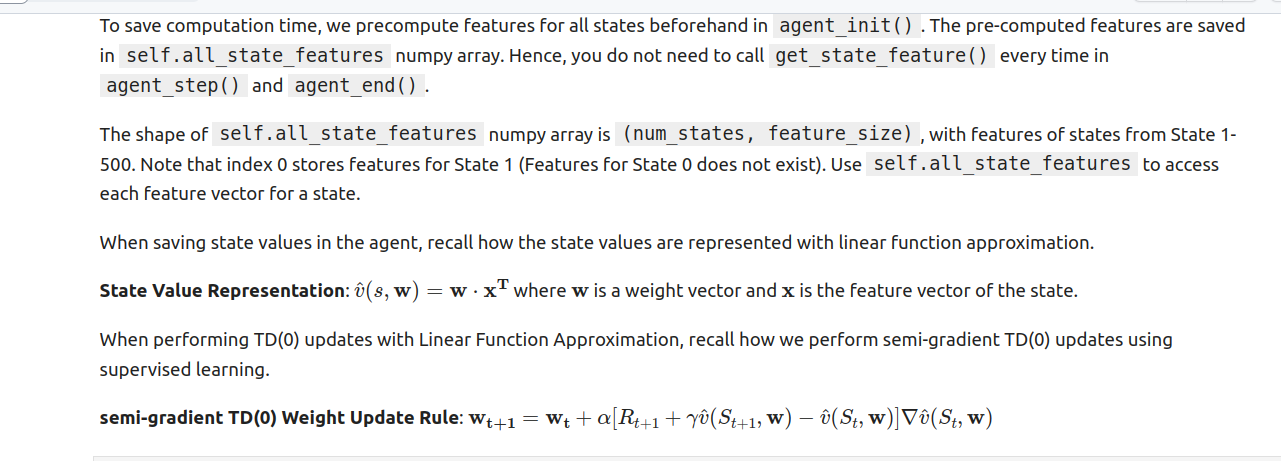

In [ ]:
class TDAgent(BaseAgent):
    def __init__(self):
        self.num_states = None
        self.num_groups = None
        self.step_size = None
        self.discount_factor = None

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD(0) state aggregation agent.

        Assume agent_info dict contains:
        {
            num_states: 500 [int],
            num_groups: int,
            step_size: float,
            discount_factor: float,
            seed: int
        }
        """

        self.rand_generator = np.random.RandomState(agent_info.get("seed"))
        self.num_states = agent_info.get("num_states")
        self.num_groups = agent_info.get("num_groups")
        self.step_size = agent_info.get("step_size")
        self.discount_factor = agent_info.get("discount_factor")

        num_states_in_group = int(self.num_states/ self.num_groups)
        self.all_states_features = np.array([get_state_feature(num_states_in_group,self.num_groups,state) for state in range(1,self.num_states +1)])
        self.weights = np.zeros(self.num_groups)

        self.last_action = None
        self.last_state = None

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            self.last_action [int] : The first action the agent takes.
        """

        action = agent_policy(self.rand_generator,state)
        self.last_state = state
        self.last_action = action
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward [float]: the reward received for taking the last action taken
            state [int]: the state from the environment's step, where the agent ended up after the last step
        Returns:
            self.last_action [int] : The action the agent is taking.
        """
        current_state_feature = self.all_states_features[state-1]
        last_state_feature = self.all_states_features[self.last_state-1]
        self.weights += self.step_size * ( reward + self.discount_factor * np.dot(self.weights,current_state_feature) - np.dot(self.weights,last_state_feature)) * last_state_feature
        action = agent_policy(self.rand_generator,state)
        self.last_state = state
        self.last_action = action
        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        last_state_feature = self.all_states_features[self.last_state-1]
        self.weights += self.step_size * (reward - np.dot(self.weights,last_state_feature)) * last_state_feature
        return


In [ ]:
%%add_to TDAgent
def agent_message(self, message):
    if message == 'get state value':
        state_value = np.dot(self.weights, self.all_state_features.T)
        return state_value

In [ ]:
true_state_val = np.load('data/true_V.npy')
state_distribution = np.load('data/state_distribution.npy')

def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

In [ ]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)

    # Sweep Agent parameters
    for num_agg_states in agent_parameters["num_groups"]:
        for step_size in agent_parameters["step_size"]:

            # save rmsve at the end of each evaluation episode
            # size: num_episode / episode_eval_frequency + 1 (includes evaluation at the beginning of training)
            agent_rmsve = np.zeros(int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1)

            # save learned state value at the end of each run
            agent_state_val = np.zeros(environment_parameters["num_states"])

            env_info = {"num_states": environment_parameters["num_states"],
                        "start_state": environment_parameters["start_state"],
                        "left_terminal_state": environment_parameters["left_terminal_state"],
                        "right_terminal_state": environment_parameters["right_terminal_state"]}

            agent_info = {"num_states": environment_parameters["num_states"],
                          "num_groups": num_agg_states,
                          "step_size": step_size,
                          "discount_factor": environment_parameters["discount_factor"]}

            print('Setting - num. agg. states: {}, step_size: {}'.format(num_agg_states, step_size))
            os.system('sleep 0.2')

            # one agent setting
            for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
                env_info["seed"] = run
                agent_info["seed"] = run
                rl_glue.rl_init(agent_info, env_info)

                # Compute initial RMSVE before training
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[0] += calc_RMSVE(current_V)

                for episode in range(1, experiment_parameters["num_episodes"]+1):
                    # run episode
                    rl_glue.rl_episode(0) # no step limit

                    if episode % experiment_parameters["episode_eval_frequency"] == 0:
                        current_V = rl_glue.rl_agent_message("get state value")
                        agent_rmsve[int(episode/experiment_parameters["episode_eval_frequency"])] += calc_RMSVE(current_V)

                # store only one run of state value
                if run == 50:
                    agent_state_val = rl_glue.rl_agent_message("get state value")

            # rmsve averaged over runs
            agent_rmsve /= experiment_parameters["num_runs"]

            save_name = "{}_agg_states_{}_step_size_{}".format('TD_agent', num_agg_states, step_size).replace('.','')

            if not os.path.exists('results'):
                os.makedirs('results')

            # save avg. state value
            np.save("results/V_{}".format(save_name), agent_state_val)

            # save avg. rmsve
            np.save("results/RMSVE_{}".format(save_name), agent_rmsve)

Setting - num. agg. states: 10, step_size: 0.01


100%|██████████| 50/50 [01:55<00:00,  2.30s/it]


Setting - num. agg. states: 10, step_size: 0.05


100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


Setting - num. agg. states: 10, step_size: 0.1


100%|██████████| 50/50 [01:54<00:00,  2.30s/it]


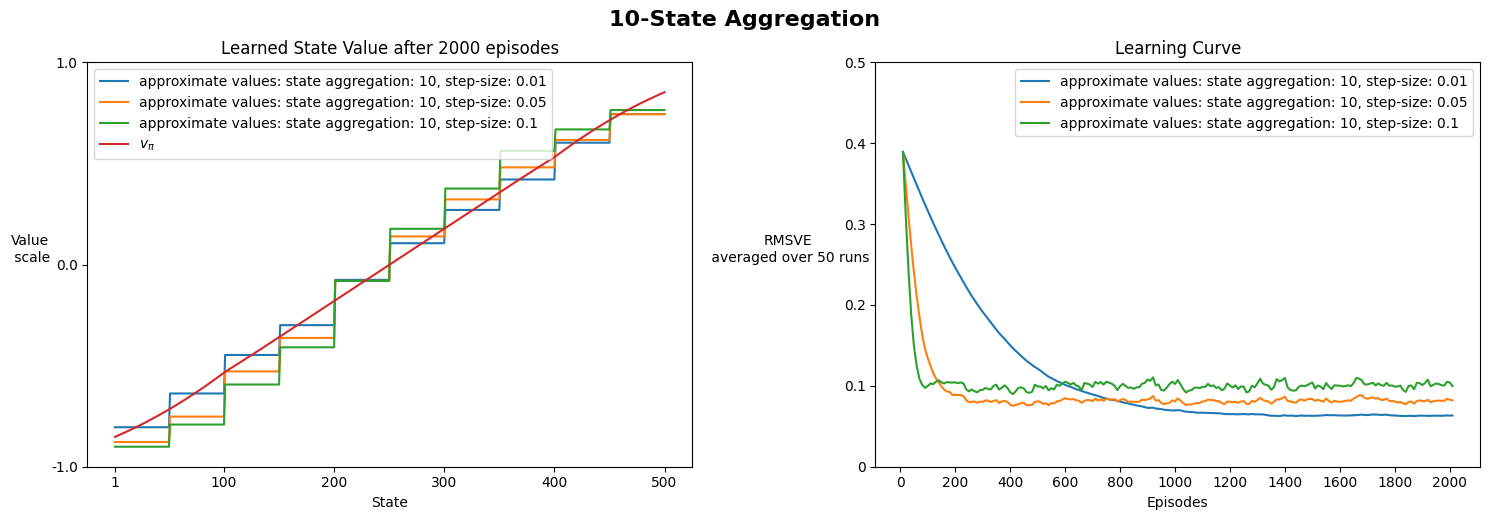

In [ ]:
experiment_parameters = {
    "num_runs" : 50,
    "num_episodes" : 2000,
    "episode_eval_frequency" : 10 # evaluate every 10 episodes
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
# Each element is an array because we will be later sweeping over multiple values
agent_parameters = {
    "num_groups": [10],
    "step_size": [0.01, 0.05, 0.1]
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)
plot_script.plot_result(agent_parameters, 'results')

In [ ]:
experiment_parameters = {
    "num_runs" : 50,
    "num_episodes" : 2000,
    "episode_eval_frequency" : 10 # evaluate every 10 episodes
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
# Each element is an array because we will be sweeping over multiple values
agent_parameters = {
    "num_groups": [10, 100, 500],
    "step_size": [0.01, 0.05, 0.1]
}

if all_correct:
    plot_script.plot_result(agent_parameters, 'correct_npy')
else:
    raise ValueError("Make sure your experiment result is correct! Otherwise the sweep results will not be displayed.")

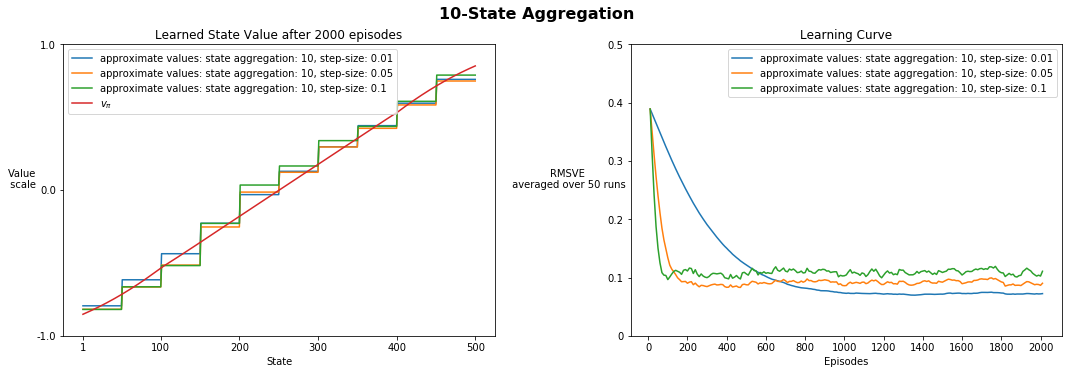

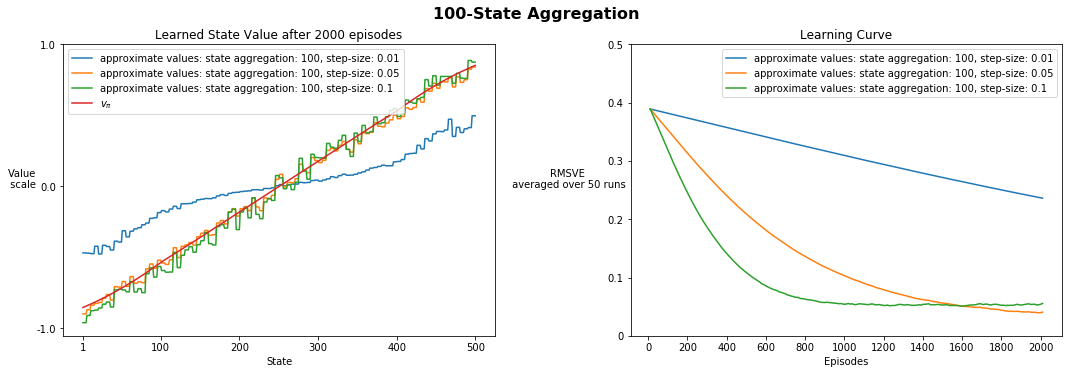

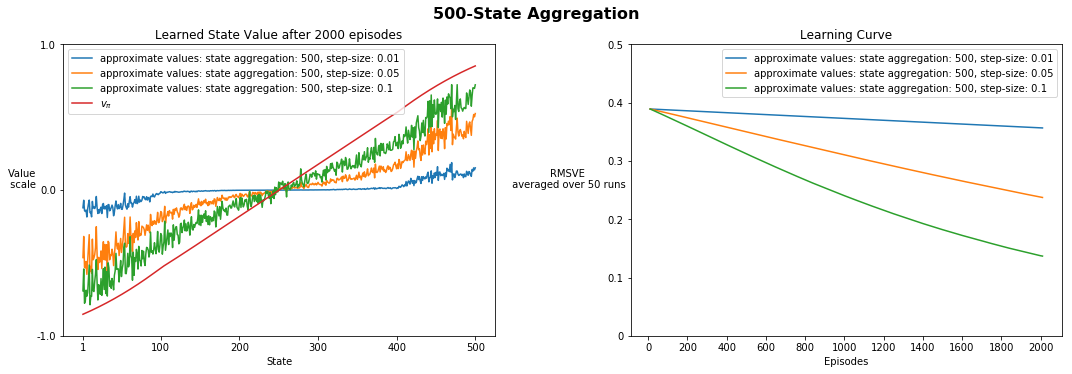

From the plots, using 100 state aggregation with step-size 0.05 reaches the best performance: the lowest RMSVE after 2000 episodes. If the agent can only be trained for 200 episodes, then 10 state aggregation with step-size 0.05 reaches the lowest error. Increasing the resolution of state aggregation makes the function approximation closer to a tabular representation, which would be able to learn exactly correct state values for all states. But learning will be slower.

Step-Size
How did different step-sizes affect learning?
The best step-size is different for different state aggregation resolutions. A larger step-size allows the agent to learn faster, but might not perform as well asymptotically. A smaller step-size causes it to learn more slowly, but may perform well asymptotically.